# Geomagnetic Conjugate Map
The purpose of this notebook is to gather relevant stations and mapping information for a geomagnetic conjugate map.

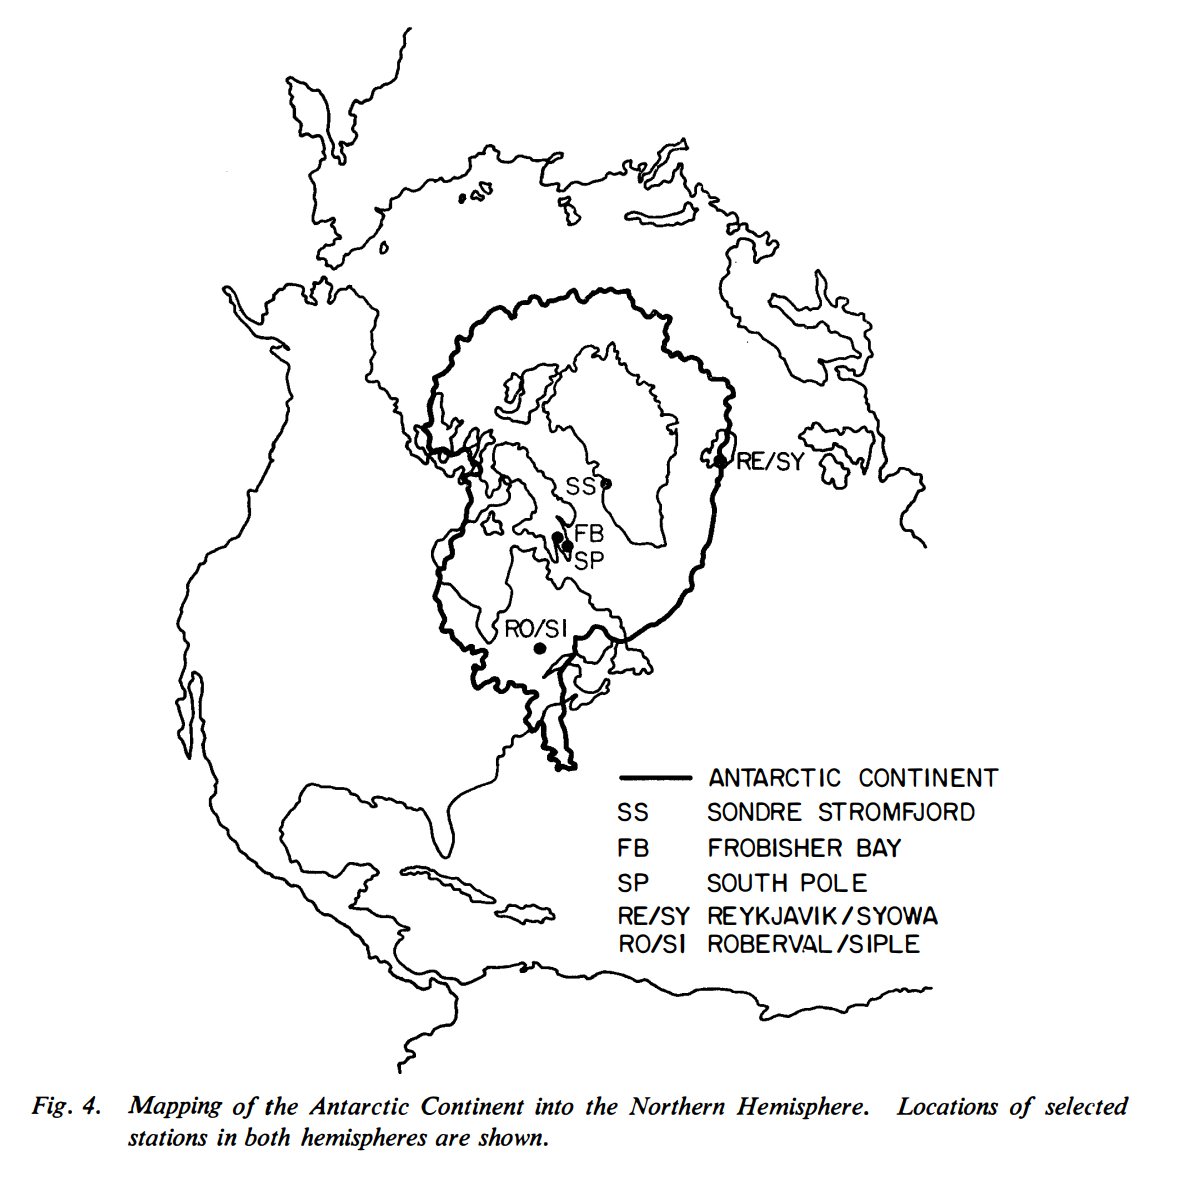

In [16]:
import numpy as np
import pandas as pd
import plotly.express as px
import json
import ogr
import geopandas as gpd

import aacgmv2
import datetime as dt
import numpy as np


import pandas as pd
smag = __import__('supermag-api')          # SuperMAG python API
logon = 'kd8oxt'                              # SuperMAG ID

# # For pulling data from CDAweb:
# from ai import cdas
# import datetime
# from matplotlib import pyplot as plt

import gpxpy
import gpxpy.gpx

## Stations and Features
First, let's collect stations and features of interest into pandas dataframes. (Make sure to include dates of operation wherever possible - want to make sure that we have that information when creating historical maps later!)

I'm collecting station information here: https://docs.google.com/spreadsheets/d/1DYVxUyF0DDpw7SoCTTIANWcNzMouLW6NB8Slq00Icc8/edit?usp=sharing

In [17]:
import pandas as pd
stations = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1DYVxUyF0DDpw7SoCTTIANWcNzMouLW6NB8Slq00Icc8'+
                   # '/edit#gid=0'
                   # '0Ak1ecr7i0wotdGJmTURJRnZLYlV3M2daNTRubTdwTXc' +
                   '/export?gid=0&format=csv',
                   # Set first column as rownames in data frame
                   index_col=0,
                   # Parse column values to datetime
                   parse_dates=['Start', 'End']
                  )
stations["Source"] = "Manual"
stations.head()  # Same result as @TomAugspurger

ID       Category Network  Nation       Institution  GLAT  \
Name                                                                      
Nain         NAN  Magnetometers   MACCS     USA  Augsburg College  56.4   
Pangnirtung  PGG  Magnetometers   MACCS     USA  Augsburg College  66.1   
Clyde River  CRV  Magnetometers   MACCS     USA  Augsburg College  70.5   
Iqaluit      IQA  Magnetometers   MACCS  Canada  Augsburg College  63.8   
Cape Dorset  CDR  Magnetometers   MACCS     USA  Augsburg College  64.2   

              GLON Start End  Notes  \
Name                                  
Nain         298.3   NaT NaT    NaN   
Pangnirtung  294.2   NaT NaT    NaN   
Clyde River  291.4   NaT NaT    NaN   
Iqaluit      291.5   NaT NaT    NaN   
Cape Dorset  283.4   NaT NaT    NaN   

                                                     Data Link  Source  
Name                                                                    
Nain         http://space.augsburg.edu/maccs/availability.h...  Manual  
Pangnirtung  http://space.augsburg.edu/maccs/availability.h...  Manual  
Clyde River  http://space.augsburg.edu/maccs/availability.h...  Manual  
Iqaluit                                                    NaN  Manual  
Cape Dorset  http://space.augsburg.edu/maccs/availability.h...  Manual

### Marc Engebretson's wish list:

- [ ] *TODO*: Get each of these into a spreadsheet/dataframe and import them to this notebook accordingly.

- [ ] Figure 1 and Table 1 in the attached file “JGRA – 2022 – Engebretson…”  show stations used in one of my recent papers.  The table contains a full list of AAL-PIP stations in Antarctica but only a partial list of stations in the other arrays mentioned.  In Figure 1 the stations in one high latitude hemisphere are mapped to their magnetically conjugate region in the other hemisphere. 
- [ ] Greenland coastal arrays:  a web site with the full list of west coast and east coast stations is
https://www.space.dtu.dk/english/research/scientific_data_and_models/magnetic_ground_stations#list  
Only one of the stations on the Greenland Ice Cap is still operating. See tables in doi.org/10.1029/2022JA030580

- [ ] British Antarctic survey chain:  Coordinates are part of the station name, as in “M85-002 – 85.36° 2.06°” in Table 1 of the attached file “JGRA – 2022 – Engebretson…”.  The full list of stations is in the attached file ”Full Record – LPM…” https://www.bas.ac.uk/project/low-power-magnetometer-lpm-network/
- [ ] AUTUMNX array coordinates are in the attached file “Connors2016…..”  doi.org/10.1186/s40623-015-0354-4 See Figure 4 (yellow circles) and Table 1.  They are also available at https://autumn.athabascau.ca/TBS_autumnxquery2.php
- [X] MACCS array coordinates are in the attached file “MACCS array and…”  (see link below)
- [ ] CANMOS array geographic coordinates are listed here:  https://geomag.nrcan.gc.ca/obs/default-en.php

### Northern Hemisphere Stations
- [ ] AMISR - should be conjugate with McMurdo
- [X] MACCS network
- [ ] North American research institutions (CWRU, MIT, NJIT, VA Tech, DTU, and other universities who have space wx/have expressed interest)
- [ ] ISRs
- [ ] All-sky cameras
- [X] Full set of magnetometer networks from SuperMAG

Let's pull some more Northern hemisphere stations from the list of instruments in the Madrigal database, at http://cedar.openmadrigal.org/instMetadata. (It would be good form to use the `madrigalWeb` python package for this if we need more data.)

In [18]:
# madrigal = pd.read_csv("madrigal.csv")
madrigal = pd.read_html("http://cedar.openmadrigal.org/instMetadata")[0]
madrigal = madrigal.rename(columns={"3-letter mnemonic": "ID", "Latitude": "GLAT", "Longitude (-180-180)":"GLON"})
madrigal = madrigal.set_index("Name")
madrigal["Source"] = "Madrigal"

# add to stations list:
stations = pd.concat([stations, madrigal], ignore_index=False)

Downloading SUPERMAG's list of stations from https://supermag.jhuapl.edu/mag/?fidelity=low&tab=stationinfo&start=2001-01-01T00%3A00%3A00.000Z&interval=23%3A59#:

(I've edited the operators column of the spreadsheet to make it digestible to pandas...)

In [19]:
supermag = pd.read_csv("20230803-11-15-supermag-stations.csv", sep = ',') 

supermag = supermag.rename(columns={"STATION-NAME":"Name", "IAGA": "ID", "GEOLAT": "GLAT", "GEOLON":"GLON", "OP1":"Network"})
supermag = supermag.set_index("Name")
supermag["Category"] = "Magnetometers"
supermag["Source"] = "SuperMAG"

# add to stations list:
stations = pd.concat([stations, supermag], ignore_index=False)

stations

ID       Category  Network  Nation       Institution   GLAT  \
Name                                                                        
Nain         NAN  Magnetometers    MACCS     USA  Augsburg College   56.4   
Pangnirtung  PGG  Magnetometers    MACCS     USA  Augsburg College   66.1   
Clyde River  CRV  Magnetometers    MACCS     USA  Augsburg College   70.5   
Iqaluit      IQA  Magnetometers    MACCS  Canada  Augsburg College   63.8   
Cape Dorset  CDR  Magnetometers    MACCS     USA  Augsburg College   64.2   
...          ...            ...      ...     ...               ...    ...   
Bor          POD  Magnetometers  IZMIRAN     NaN               NaN  61.58   
Tormestorp   TOP  Magnetometers    IMAGE     NaN               NaN  56.09   
Augusta      R11  Magnetometers  MAGSTAR     NaN               NaN   44.3   
Grant        R12  Magnetometers  MAGSTAR     NaN               NaN   47.5   
Pawnee       R13  Magnetometers  MAGSTAR     NaN               NaN   40.2   

              GLON Start End  Notes  ... Altitude (km) Principal Investigator  \
Name                                 ...                                        
Nain         298.3   NaT NaT    NaN  ...           NaN                    NaN   
Pangnirtung  294.2   NaT NaT    NaN  ...           NaN                    NaN   
Clyde River  291.4   NaT NaT    NaN  ...           NaN                    NaN   
Iqaluit      291.5   NaT NaT    NaN  ...           NaN                    NaN   
Cape Dorset  283.4   NaT NaT    NaN  ...           NaN                    NaN   
...            ...   ...  ..    ...  ...           ...                    ...   
Bor          90.03   NaT NaT    NaN  ...           NaN                    NaN   
Tormestorp   13.18   NaT NaT    NaN  ...           NaN                    NaN   
Augusta      290.4   NaT NaT    NaN  ...           NaN                    NaN   
Grant        242.3   NaT NaT    NaN  ...           NaN                    NaN   
Pawnee       256.3   NaT NaT    NaN  ...           NaN                    NaN   

             PI Email AACGMLON AACGMLAT OPERATOR-NUM  OP2  OP3  Unnamed: 10  \
Name                                                                          
Nain              NaN      NaN      NaN          NaN  NaN  NaN          NaN   
Pangnirtung       NaN      NaN      NaN          NaN  NaN  NaN          NaN   
Clyde River       NaN      NaN      NaN          NaN  NaN  NaN          NaN   
Iqaluit           NaN      NaN      NaN          NaN  NaN  NaN          NaN   
Cape Dorset       NaN      NaN      NaN          NaN  NaN  NaN          NaN   
...               ...      ...      ...          ...  ...  ...          ...   
Bor               NaN   163.04    57.25          1.0  NaN  NaN          NaN   
Tormestorp        NaN    90.96    52.56          1.0  NaN  NaN          NaN   
Augusta           NaN     9.46    54.00          1.0  NaN  NaN          NaN   
Grant             NaN   -57.23    54.01          1.0  NaN  NaN          NaN   
Pawnee            NaN   -38.59    49.50          1.0  NaN  NaN          NaN   

            Unnamed: 11  
Name                     
Nain                NaN  
Pangnirtung         NaN  
Clyde River         NaN  
Iqaluit             NaN  
Cape Dorset         NaN  
...                 ...  
Bor                 NaN  
Tormestorp          NaN  
Augusta             NaN  
Grant               NaN  
Pawnee              NaN  

[906 rows x 23 columns]

Alternatively, we can pull data using the SuperMAG API:

### Antarctic Stations
- [x] AALPIP stations
- [x] Import COMNAP data - use https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/tree/master

In [20]:
url = "https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/raw/master/dist/COMNAP_Antarctic_Facilities_Master.xls"

comnap_df = pd.read_excel(url)

comnap = comnap_df.rename(columns={"English Name":"Name", "Type": "Category", "Latitude (DD)": "GLAT", "Longitude (DD)":"GLON", "Operator (primary)":"Nation"})
comnap = comnap.set_index("Name")
comnap["Source"] = "COMNAP"

# add to stations list:
stations = pd.concat([stations, comnap], ignore_index=False)

# stations

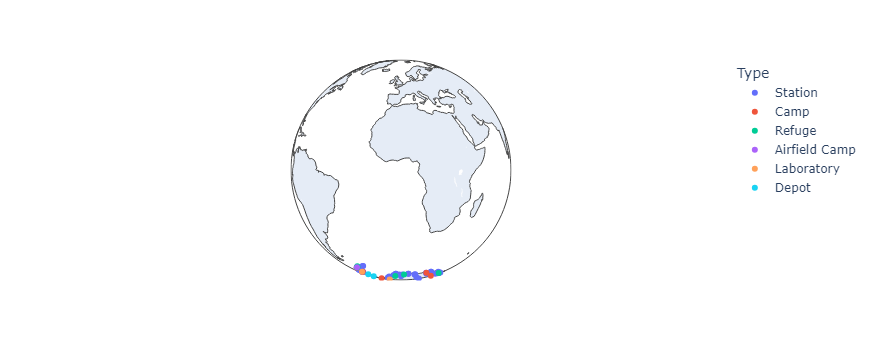

In [21]:
import plotly.express as px
fig = px.scatter_geo(comnap_df,
                    lat=comnap_df["Latitude (DD)"],
                    lon=comnap_df["Longitude (DD)"],
                    hover_name="English Name",
                    color = "Type")
fig.update_geos(projection_type="orthographic")
fig.show()

### Eclipse Paths
- [ ] June 2020 Eclipse 
- [ ] December 2020 Eclipse 

Shunrong Zhang computed paths at various elevations for the 2017 eclipse. Those can be found here: http://aeronomy.haystack.mit.edu/share/eclipse_2017/

In [22]:
url = 'http://aeronomy.haystack.mit.edu/share/eclipse_2017/eclipse20170821.txt.000km.hiRes'
header = ["YEAR/M/DD", "HH:MM:SS",  "UTC", "MIN Magni", "LAT", "LONG"]
#Min Magni = minimum obscuration magnitude (ratio), based on the fraction of the visible solar disk area screened by the Moon
eclipse = pd.read_csv(url, sep='\s+', names = header)
eclipse

YEAR/M/DD  HH:MM:SS        UTC  MIN Magni     LAT    LONG
0    2017/8/21  15:58:00  15.966667    0.20739  31.094 -156.25
1    2017/8/21  15:59:00  15.983333    0.22105  32.656 -157.00
2    2017/8/21  16:00:00  16.000000    0.23148  31.875 -157.00
3    2017/8/21  16:01:00  16.016667    0.24205  31.875 -157.25
4    2017/8/21  16:02:00  16.033333    0.25448  31.875 -157.50
..         ...       ...        ...        ...     ...     ...
291  2017/8/21  20:49:00  20.816667    0.25561   2.656  -40.75
292  2017/8/21  20:50:00  20.833333    0.24205   2.812  -41.00
293  2017/8/21  20:51:00  20.850000    0.23326   2.656  -41.25
294  2017/8/21  20:52:00  20.866667    0.22170   2.656  -41.50
295  2017/8/21  20:53:00  20.883333    0.20996   2.656  -41.75

[296 rows x 6 columns]

In [60]:
pd.DataFrame(90*np.random.random((5, 2)))


0          1
0  37.604624  64.144724
1  88.529662  75.856511
2  42.074740  22.140237
3  28.306842  22.746985
4  66.372560  72.940523

In [69]:
# import pandas as pd
# import numpy as np

df = eclipse[['LAT', 'LONG']]

# print(df)

import gpxpy
import gpxpy.gpx

gpx = gpxpy.gpx.GPX()

# Create first track in our GPX:
gpx_track = gpxpy.gpx.GPXTrack()
gpx.tracks.append(gpx_track)

# Create first segment in our GPX track:
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Create points:
for idx in df.index:
    gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(df.loc[idx, 'LAT'], df.loc[idx, 'LONG']))

# print(gpx.to_xml())

with open('eclipse.gpx', 'w') as f:
    f.write(gpx.to_xml())

### Satellite Paths
- [ ] GOES East

## Maps

### Global Map
- [x] Let's begin by plotting all the points on a globe map using plotly express.

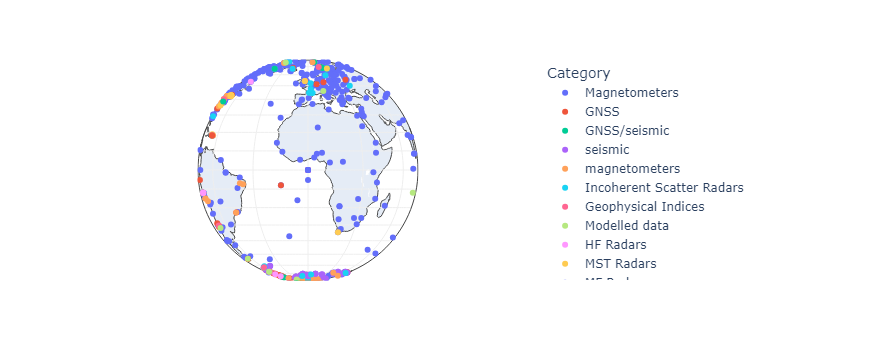

In [23]:
fig = px.scatter_geo(stations.reset_index(),
                    lat=stations["GLAT"],
                    lon=stations["GLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Category")
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("all-stations.html")

### Antarctic Coastline
- [X] Pull data from https://data.bas.ac.uk/items/70ac5759-34ee-4f39-9069-2116db592340/#item-details-citation
- [ ] Map the data with plotly express or similar
- [ ] Convert the coordinates to geomagnetic coordinates and plot them

In [24]:
url = 'https://github.com/nvkelso/natural-earth-vector/raw/master/10m_physical/ne_10m_antarctic_ice_shelves_lines.shp'

import shapefile

# shp = shapefile.Reader(url)
# shp = shapefile.Reader('add_contours_medium_res_v7.3/add_contours_medium_res_v7.3.dbf')
shp = shapefile.Reader('add_contours_medium_res_v7.3.zip')

# Get the number of features in the shp file.
num_features = shp.shapeRecords()

# Create an empty array to store the latitude and longitude coordinates.
coordinates = []

# # # Iterate over the features in the shp file.
# for i in range(num_features):
#     # Get the coordinates of the current feature.
#     points = shp.shape(i).points

#     # Add the coordinates to the array.
#     coordinates.extend(points)

shp

In [26]:
import geopandas

shp_file = geopandas.read_file('add_contours_low_res_v7.2.zip')
shp_file.to_file('myshpfile.geojson', driver='GeoJSON')

In [27]:
vars(shp)

{'shp': <tempfile._TemporaryFileWrapper at 0x7f3fb4d87eb0>,
 'shx': <tempfile._TemporaryFileWrapper at 0x7f3fb4d87ca0>,
 'dbf': <tempfile._TemporaryFileWrapper at 0x7f3fb4051eb0>,
 '_files_to_close': [<tempfile._TemporaryFileWrapper at 0x7f3fb4d87eb0>,
 'shapeName': 'Not specified',
 '_offsets': [],
 'shpLength': 92857852,
 'numRecords': 631,
 'numShapes': 631,
 'fields': [('DeletionFlag', 'C', 1, 0),
  ['gid', 'N', 10, 0],
  ['contour', 'N', 24, 15],
  ['source', 'C', 254, 0],
  ['sourcedate', 'D', 8, 0],
  ['revdate', 'D', 8, 0]],
 '_Reader__dbfHdrLength': 193,
 '_Reader__fieldLookup': {'DeletionFlag': 0,
  'gid': 1,
  'contour': 2,
  'source': 3,
  'sourcedate': 4,
  'revdate': 5},
 'encoding': 'utf-8',
 'encodingErrors': 'strict',
 'shapeType': 3,
 'bbox': [-2657164.616199996, -2113952.34375, 2581860.5468750005, 2293541.4941000007],
 'zbox': [0.0, 0.0],
 'mbox': [0.0, 0.0],
 '_Reader__recordLength': 305,
 '_Reader__fullRecStruct': <_struct.Struct at 0x7f3fb3fb6ab0>,
 '_Reader__full

In [ ]:
# vars(num_features[1].shape.points)

In [30]:
# CODE TO CONVERT SHAPEFILE TO GEOJSON - Only needed to run this once.

import geopandas as gpd
# set the filepath and load
# fp = "add_coastline_low_res_line_v7_2.shp"
fp = "add_contours_low_res_v7.2.zip"
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
#Export it as GeoJSON
map_df.to_file("antarctic_coastline.json", driver='GeoJSON')

In [31]:
# with open('antarctic_coastline.json') as f:
#   Antarctic_coast = json.load(f)
# with open('Medium_resolution_vector_polygons_of_the_Antarctic_coastline.geojson') as f:
with open('myshpfile.geojson') as f:
  Antarctic_coast = json.load(f)

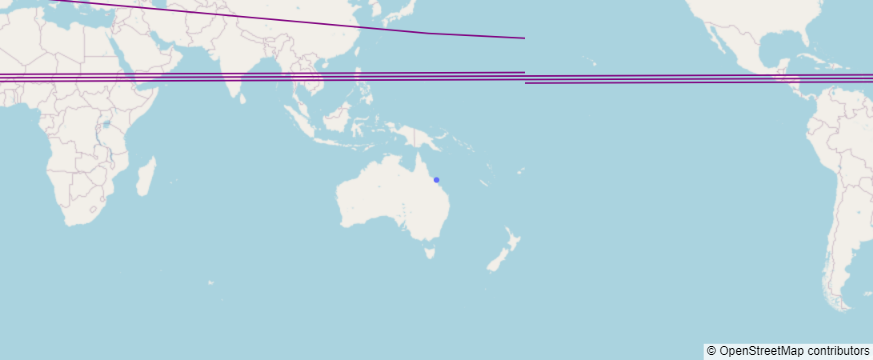

In [35]:
# import geopandas as gpd
import plotly.express as px
import json
# geojson = {
# "type": "FeatureCollection",
# "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::4283" } },
# "features": [
# { "type": "Feature", "properties": { "OBJECTID": 2282, "SORT_GBR_I": "20039", "LABEL_ID": "20-039", "SUB_NO": 100, "CODE": "20-039-100-106", "UNIQUE_ID": "20039100106", "FEATURE_C": 106, "GBR_NAME": "Hill Rock", "FEAT_NAME": "Rock", "QLD_NAME": "Hill Rock", "X_LABEL": "20-039S", "GBR_ID": "20039", "LOC_NAME_S": "Hill Rock (20-039)", "LOC_NAME_L": "Hill Rock (20-039)", "X_COORD": 148.90635681000001, "Y_COORD": -20.25865936, "Area_HA": 0.0, "GlobalID": "{6CFEA6F6-33A2-444A-835B-0003206EBA49}", "Shape_STAr": 14139.6796875, "Shape_STLe": 471.01884611600002 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 148.90694393116658, -20.259096202918855 ], [ 148.906921432860258, -20.259141198606248 ], [ 148.906754946292011, -20.259253691138628 ], [ 148.906687452271484, -20.259253691138628 ], [ 148.906655954642673, -20.259244690660317 ], [ 148.906619957352575, -20.259235691867001 ], [ 148.906570461078786, -20.259231191627361 ], [ 148.90651646604195, -20.259222192833235 ], [ 148.906302341814211, -20.259159602404967 ], [ 148.906223988958516, -20.259136699206643 ], [ 148.906196990990964, -20.259132199806906 ], [ 148.906156494039664, -20.259123201007046 ], [ 148.906124997309178, -20.259118700764201 ], [ 148.905985260773463, -20.259177555334624 ], [ 148.905936012434609, -20.259145698848446 ], [ 148.905900015144567, -20.259114202206661 ], [ 148.905882015601208, -20.259078205314452 ], [ 148.905873017177015, -20.259037707325927 ], [ 148.905864017854498, -20.258997211012321 ], [ 148.905859518193239, -20.258961213250245 ], [ 148.905850518870693, -20.258925217165245 ], [ 148.905850517972397, -20.258884719979569 ], [ 148.905850518870693, -20.258844222783306 ], [ 148.905854417559027, -20.25880628498949 ], [ 148.905859518193239, -20.25878122768551 ], [ 148.905859518193239, -20.258736231893799 ], [ 148.905850517972397, -20.258682236420832 ], [ 148.905859518193239, -20.258655238255969 ], [ 148.905850518870693, -20.258619241257328 ], [ 148.905850517972397, -20.258592243081473 ], [ 148.905850518870693, -20.258551745808919 ], [ 148.905864016956144, -20.258506749950669 ], [ 148.905868516617403, -20.258470752917578 ], [ 148.90586851841411, -20.258434755876166 ], [ 148.905873017177015, -20.258380760298351 ], [ 148.90588651616082, -20.258326764701771 ], [ 148.905891014923725, -20.25828626820272 ], [ 148.905900014246271, -20.25825476970104 ], [ 148.905904514805826, -20.258218772609524 ], [ 148.905922512552536, -20.25818277635242 ], [ 148.905922512552536, -20.258146779244225 ], [ 148.905998580094177, -20.258045355404413 ], [ 148.906057503288594, -20.257966792735232 ], [ 148.906106997765789, -20.257926296984994 ], [ 148.906165494260449, -20.257912796994663 ], [ 148.906205990313481, -20.257921796707411 ], [ 148.906232988281033, -20.257935295854242 ], [ 148.906273485232333, -20.257948794999852 ], [ 148.906295982640302, -20.257966792735221 ], [ 148.906462470106902, -20.258097282996108 ], [ 148.906493967735656, -20.258119780986227 ], [ 148.906516465143653, -20.258151278672489 ], [ 148.906547962772464, -20.258191775206793 ], [ 148.906570461977083, -20.258218772609524 ], [ 148.90659295938508, -20.258259269968963 ], [ 148.906624457013834, -20.258304265898925 ], [ 148.906646955320156, -20.258349262658626 ], [ 148.906750446630753, -20.258515749629034 ], [ 148.906790942683756, -20.258542746975422 ], [ 148.906831439635141, -20.258556246068217 ], [ 148.906871936586413, -20.258560746327401 ], [ 148.906898934553993, -20.258574243733147 ], [ 148.906943932064848, -20.258601242754846 ], [ 148.9069546902887, -20.258654134260489 ], [ 148.906948430827839, -20.258713733993034 ], [ 148.906934931844063, -20.258740732147746 ], [ 148.90692593341987, -20.258961214092974 ], [ 148.90694393116658, -20.259010710065613 ], [ 148.906948430827839, -20.259064706267022 ], [ 148.90694393116658, -20.259096202918855 ] ] ] } }] 
# }

geojson = Antarctic_coast

gdf = gpd.GeoDataFrame.from_features(geojson)
point = (148.90635, -20.25866)


fig = px.scatter_mapbox(lat=[point[1]], lon=[point[0]]).update_layout(
        mapbox={
            "style": "open-street-map",
            "zoom": 1,
            "layers": [
                {
                    "source": json.loads(gdf.geometry.to_json()),
                    "below": "traces",
                    "type": "line",
                    "color": "purple",
                    "line": {"width": 1.5},
                }
            ],
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )

# fig.update_geos(projection_type="azimuthal equidistant")
fig.update_geos(projection_type="mt flat polar quartic")
fig.update_geos(center_lat=-90)
fig.update_geos(center_lon=0)


fig.show()


In [36]:
# gdf.geometry[0].__geom__
gdf.geometry[0].exterior.coords.xy[0] # latitude


AttributeError: 'LineString' object has no attribute 'exterior'

In [42]:
# gdf.geometry[0].union(gdf.geometry[4])
# gdf.geometry[

SyntaxError: invalid syntax (2463980538.py, line 2)

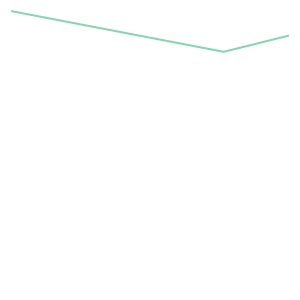

In [43]:

foo = gdf.geometry[0]
for i in range(len(gdf)):
    if(gdf.surface[i] == 'land'):
        if i != 1223: # this one messes up the geometry...
            try:
                foo = foo.union(gdf.geometry[i])
            except:
                print(i)
                continue
foo

### Coordinate Conversions
- [X] Create/find a function to convert geographic to geomagnetic coordinates. Might try https://pypi.org/project/aacgmv2/ or https://github.com/space-physics/geo2mag

In [48]:
# Prallocate columns for magnetic coordinates:
stations['MLAT'] = np.nan
stations['MLON'] = np.nan
stations['MALT'] = np.nan

# Iterate over the DataFrame
for index, row in stations.iterrows():
    try:
        lat = float(row["GLAT"])
        lon = float(row["GLON"])
        dtime = dt.datetime(2013, 11, 3)
        method_code = "G2A"

        # Apply the aacgmv2 function
        # stations['MLAT'][row], stations['MLON'][row] = aacgmv2.wrapper.convert_latlon(lat, lon, 300, dtime, method_code)
        stations['MLAT'][index], stations['MLON'][index], stations['MALT'][index]  =  aacgmv2.wrapper.convert_latlon(lat, lon, 300, dtime, method_code)
    except Exception as e:
        print('Ran into a problem with ' + index)
        print(e)
        continue

stations

/tmp/ipykernel_2856/927070386.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ran into a problem with Inuvik, NT
could not convert string to float: '−133.76'
Ran into a problem with Whitehorse, YT
could not convert string to float: '−135.09'
Ran into a problem with Fort St John, BC
could not convert string to float: '−120.74'
Ran into a problem with La Ronge, SK
could not convert string to float: '−105.26'
Ran into a problem with Meanook, AB
could not convert string to float: '−113.34'
Ran into a problem with Athabasca, AB
could not convert string to float: '−113.64'
Ran into a problem with Saskatoon, SK
could not convert string to float: '−106.53'
Ran into a problem with Red Deer, AB
could not convert string to float: '−113.83'
Ran into a problem with Calgary, AB
could not convert string to float: '−114.33'
Ran into a problem with Lethbridge, AB
could not convert string to float: '−112.86'
Ran into a problem with EISCAT combined IS Radars
could not convert string to float: 'None'
Ran into a problem with TGCM/TIGCM model
could not convert string to float: 'None'

unable to perform conversion at 14.4, -17.0 300.0 km, 2013-11-03 00:00:00 using method 0 <AACGM_v2_Convert returned error code -1>. Recall that AACGMV2 is undefined near the equator.
unable to perform conversion at 9.0, 7.4 300.0 km, 2013-11-03 00:00:00 using method 0 <AACGM_v2_Convert returned error code -1>. Recall that AACGMV2 is undefined near the equator.
unable to perform conversion at 5.3, -4.1 300.0 km, 2013-11-03 00:00:00 using method 0 <AACGM_v2_Convert returned error code -1>. Recall that AACGMV2 is undefined near the equator.
unable to perform conversion at 9.6, -13.7 300.0 km, 2013-11-03 00:00:00 using method 0 <AACGM_v2_Convert returned error code -1>. Recall that AACGMV2 is undefined near the equator.


Ran into a problem with USU Mesospheric Temperature Mapper
could not convert string to float: 'None'


unable to perform conversion at 8.5, 4.7 300.0 km, 2013-11-03 00:00:00 using method 0 <AACGM_v2_Convert returned error code -1>. Recall that AACGMV2 is undefined near the equator.
unable to perform conversion at 6.5, 3.3 300.0 km, 2013-11-03 00:00:00 using method 0 <AACGM_v2_Convert returned error code -1>. Recall that AACGMV2 is undefined near the equator.


ID       Category Network         Nation  \
Name                                                                 
Nain                     NAN  Magnetometers   MACCS            USA   
Pangnirtung              PGG  Magnetometers   MACCS            USA   
Clyde River              CRV  Magnetometers   MACCS            USA   
Iqaluit                  IQA  Magnetometers   MACCS         Canada   
Cape Dorset              CDR  Magnetometers   MACCS            USA   
...                      ...            ...     ...            ...   
Shackleton Glacier Camp  NaN           Camp     NaN  United States   
Siple Dome               NaN           Camp     NaN  United States   
WAIS Divide              NaN           Camp     NaN  United States   
Artigas                  NaN        Station     NaN        Uruguay   
Ruperto Elichiribehety   NaN        Station     NaN        Uruguay   

                              Institution       GLAT        GLON Start End  \
Name                                                                         
Nain                     Augsburg College       56.4       298.3   NaT NaT   
Pangnirtung              Augsburg College       66.1       294.2   NaT NaT   
Clyde River              Augsburg College       70.5       291.4   NaT NaT   
Iqaluit                  Augsburg College       63.8       291.5   NaT NaT   
Cape Dorset              Augsburg College       64.2       283.4   NaT NaT   
...                                   ...        ...         ...   ...  ..   
Shackleton Glacier Camp               NaN -85.086232 -175.289469   NaT NaT   
Siple Dome                            NaN -81.653771 -149.001846   NaT NaT   
WAIS Divide                           NaN -79.471286 -112.072154   NaT NaT   
Artigas                               NaN -62.184551  -58.902442   NaT NaT   
Ruperto Elichiribehety                NaN -63.402372  -56.990907   NaT NaT   

                         Notes  ... Elevation (meters) Elevation Datum  \
Name                            ...                                      
Nain                       NaN  ...                NaN             NaN   
Pangnirtung                NaN  ...                NaN             NaN   
Clyde River                NaN  ...                NaN             NaN   
Iqaluit                    NaN  ...                NaN             NaN   
Cape Dorset                NaN  ...                NaN             NaN   
...                        ...  ...                ...             ...   
Shackleton Glacier Camp    NaN  ...                NaN             NaN   
Siple Dome                 NaN  ...                NaN             NaN   
WAIS Divide                NaN  ...                NaN             NaN   
Artigas                    NaN  ...               17.0             MSL   
Ruperto Elichiribehety     NaN  ...               28.0             MSL   

                         Peak Population Power Supply Types  \
Name                                                          
Nain                                 NaN                NaN   
Pangnirtung                          NaN                NaN   
Clyde River                          NaN                NaN   
Iqaluit                              NaN                NaN   
Cape Dorset                          NaN                NaN   
...                                  ...                ...   
Shackleton Glacier Camp             20.0                NaN   
Siple Dome                          10.0                NaN   
WAIS Divide                         40.0                NaN   
Artigas                             50.0        Fossil Fuel   
Ruperto Elichiribehety               8.0        Fossil Fuel   

                                                                 Photo URL  \
Name                                                                         
Nain                                                                   NaN   
Pangnirtung                                                            NaN   
Clyde

Now to save it as a .gpx file: (Run `pip install gpxpy` if you don't have it installed already)

## Graticules
- [X] Figure out how to plot graticules (lat/lon lines) for both geographic coordinates.
- [ ] Figure out how to plot graticules for magnetic coordinates.

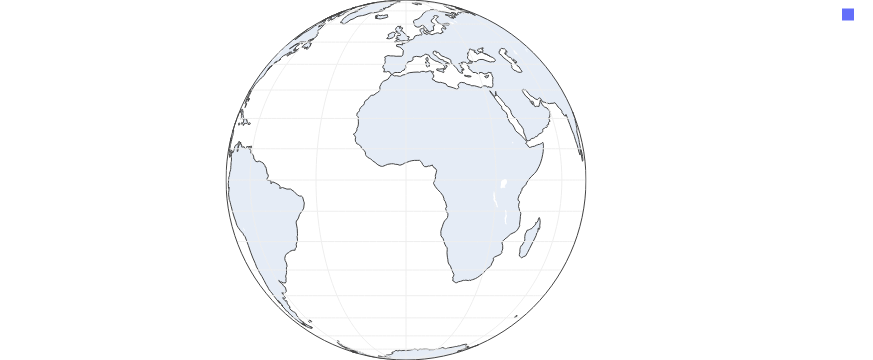

In [47]:
# gdf = geopandas.read_file(file_path)
gdf = gdf.explode(ignore_index=True)

fig = px.choropleth(
    gdf,
    geojson=gdf.geometry,
    # color='surface',
    # scope="north america",
    locations=gdf.index##['surface']
)

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Citations
- Please cite this item as 'Gerrish, L., Ireland, L., Fretwell, P., & Cooper, P. (2023). High resolution vector polylines of the Antarctic coastline (7.7) [Data set]. UK Polar Data Centre, Natural Environment Research Council, UK Research & Innovation. https://doi.org/10.5285/70ac5759-34ee-4f39-9069-2116db592340'. If using for a graphic or if short on space, please cite as 'data from the SCAR Antarctic Digital Database, 2023'

- Shepherd, S. G. (2014), Altitude‐adjusted corrected geomagnetic coordinates: Definition and functional approximations, Journal of Geophysical Research: Space Physics, 119, 7501–7521, doi:10.1002/2014JA020264.

- Connors, M., Schofield, I., Reiter, K. et al. The AUTUMNX magnetometer meridian chain in Québec, Canada. Earth Planet Sp 68, 2 (2016). https://doi.org/10.1186/s40623-015-0354-4

- Gjerloev, J. W. (2012), The SuperMAG data processing technique, J. Geophys. Res., 117, A09213, doi:10.1029/2012JA017683.
- Gjerloev, J. W. (2009), A Global Ground-Based Magnetometer Initiative, EOS, 90, 230-231, doi:10.1029/2009EO270002.

### Other stuff to try....

- Animated plot, like the one in this example (https://rstudio-pubs-static.s3.amazonaws.com/600936_f56ee4248a3f4b5098e49ab7a56dc1ab.html), showing the movement of magnetic coordinates over time